In [1]:
!pip install numpy pandas tensorflow matplotlib

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 24.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/dataset5/frm45_pro_test/features45.csv')

# Specify feature columns and the target column
feature_columns = ['frame_name', 'left_elbow_angle', 'right_elbow_angle',
                   'left_elbow_velocity', 'right_elbow_velocity', 'left_wrist_velocity',
                   'right_wrist_velocity', 'left_heel_velocity', 'right_heel_velocity',
                   'left_foot_index_velocity', 'right_foot_index_velocity']  # Example of all features
target_column = 'class_name'  # Assuming 'Class' is your target column

# Ensure the target column is part of the dataset
if target_column not in data.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset.")

# Prepare features (X) and targets (y)
X = data[feature_columns]
y = data[target_column]

# We need to ensure that we stratify by class. For stratification, a single column is needed, hence we'll use 'Class'
class_labels = y  # Since 'y' is already the target class

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=class_labels, random_state=42)

# Optionally, verify the stratification and the split
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Save the splits to new CSV files for future use
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv('/content/drive/MyDrive/dataset5/frm45_pro_test/frm45test_train.csv', index=False)
test_data.to_csv('/content/drive/MyDrive/dataset5/frm45_pro_test/frm45test_test.csv', index=False)

print("Data has been split and saved into training and testing CSV files.")


Training set size: 439 samples
Testing set size: 110 samples
Data has been split and saved into training and testing CSV files.


In [5]:
import numpy as np
import pandas as pd

def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Here we're extracting sequences of length n_steps for features
        X.append(data.iloc[i:(i + n_steps), :-3].values)
        # Assuming the last three columns are the target values and we're predicting the next step
        y.append(data.iloc[i + n_steps, -3:].values)
    return np.array(X), np.array(y)

# Load your training and testing datasets
train_data = pd.read_csv('/content/drive/MyDrive/dataset5/frm45_pro_test/frm45test_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/dataset5/frm45_pro_test/frm45test_test.csv')

# Number of timesteps in the input sequence
n_steps = 5  # You can adjust this based on your specific needs

# Generate sequences for training data
X_train, y_train = create_sequences(train_data, n_steps)
X_test, y_test = create_sequences(test_data, n_steps)

# Example output
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (434, 5, 9)
y_train shape: (434, 3)
X_test shape: (105, 5, 9)
y_test shape: (105, 3)


In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/dataset5/frm45_pro_test/features45.csv')

# Normalize the coordinate data
scaler = MinMaxScaler()
data.iloc[:, 2:] = scaler.fit_transform(data.iloc[:, 2:])

# Function to create sequences
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data.iloc[i:i + sequence_length]
        labels = sequence['class_name']  # Assuming 'class_name' is your identifier for individuals
        if len(set(labels)) == 1:  # Ensuring all frames in the sequence belong to the same individual
            X.append(sequence.iloc[:, 2:-1].values)  # All columns except 'class_name' and 'frame_name'
            y.append(labels.iloc[0])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10  # For example, 10 frames per sequence

# Create sequences
X, y = create_sequences(data, sequence_length)


In [19]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode class labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    LSTM(50),
    Dense(50, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer for classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/30
13/13 [==============================] - 5s 102ms/step - loss: nan - accuracy: 0.1495 - val_loss: nan - val_accuracy: 0.1531
Epoch 2/30
13/13 [==============================] - 0s 33ms/step - loss: nan - accuracy: 0.1495 - val_loss: nan - val_accuracy: 0.1531
Epoch 3/30
13/13 [==============================] - 0s 29ms/step - loss: nan - accuracy: 0.1495 - val_loss: nan - val_accuracy: 0.1531
Epoch 4/30
13/13 [==============================] - 0s 26ms/step - loss: nan - accuracy: 0.1495 - val_loss: nan - val_accuracy: 0.1531
Epoch 5/30
13/13 [==============================] - 0s 29ms/step - loss: nan - accuracy: 0.1495 - val_loss: nan - val_accuracy: 0.1531


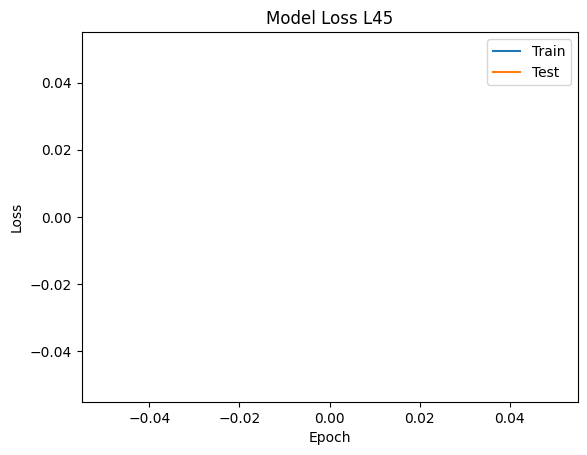

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss L45')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


# Display the plot
plt.show()
